In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectKBest, chi2, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from plots_draw import draw_cat, draw_num
from stats_methods import sigma_method

from utilities import transform_data

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [36]:
train_df = pd.read_csv('train.csv', sep=',', header=0, index_col=False)
cat_cols = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [37]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
3,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
4,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S


In [38]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [39]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,534.000000,534.000000,534.000000,534,534,432.000000,534.000000,534.00000,534,534.000000,120,534
unique,NaN,NaN,NaN,534,2,NaN,NaN,NaN,447,NaN,102,3
top,NaN,NaN,NaN,"Lefebre, Miss. Jeannie",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,346,NaN,NaN,NaN,6,NaN,3,380
mean,438.878277,0.391386,2.327715,NaN,NaN,29.612662,0.548689,0.38015,NaN,32.780453,NaN,NaN
std,256.203078,0.488518,0.839514,NaN,NaN,14.740699,1.206793,0.81936,NaN,52.203248,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.00000,NaN,0.000000,NaN,NaN
25%,213.250000,0.000000,2.000000,NaN,NaN,20.000000,0.000000,0.00000,NaN,7.895800,NaN,NaN
50%,435.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.00000,NaN,13.000000,NaN,NaN
75%,654.750000,1.000000,3.000000,NaN,NaN,38.250000,1.000000,0.00000,NaN,31.275000,NaN,NaN


In [40]:
print(f'Кол-во записей: {len(train_df)}')
train_df.isnull().sum()

Кол-во записей: 534


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            102
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          414
Embarked         0
dtype: int64

### Сделаем графики рассеивания

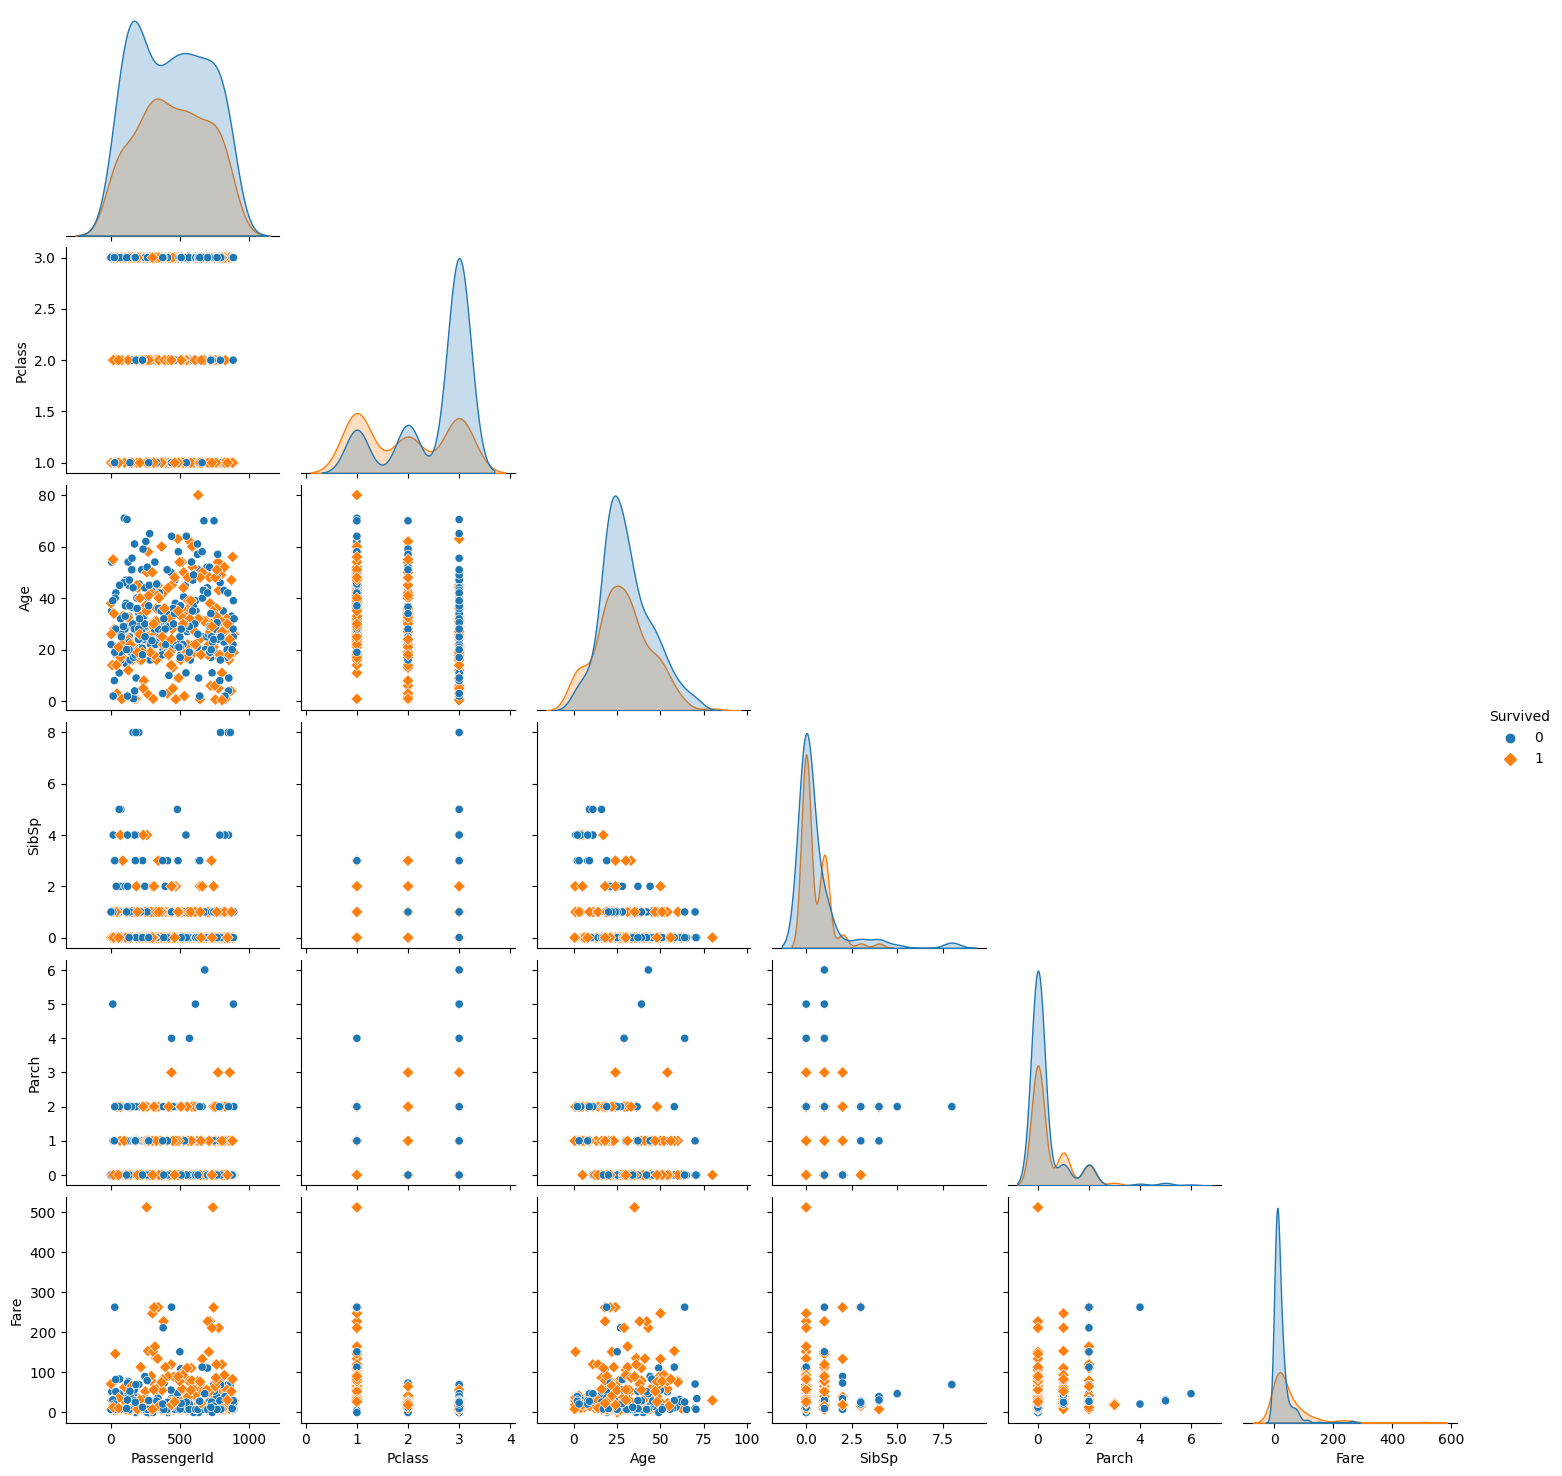

In [41]:
sns.pairplot(train_df, hue="Survived", corner=True, markers=["o", "D"])

#### Произведём заполнение пропусков, отбрасывание столбцов, которые не нужны, нормализацию и кодирование категориальных признаков

In [42]:
train_df = transform_data(train_df, num_cols, cat_cols, 2)

#### Разобьём данные так, чтобы в переменной y лежала целевая переменная, а в x всё остальное

In [43]:
all_cols = train_df.columns[1:]
x = train_df[all_cols]
y = train_df['Survived']

#### Проведём отбор информативных признаков

##### Метод фильтрации (Inforamtion Gain)

In [44]:
# select = SelectKBest(chi2, k=4)
# y_new = select.fit_transform(x, y)
# scores = [roc_auc_score(y, x_new[:, 1])]

# importances = mutual_info_classif(x, y)
# feature_importances = pd.Series(importances, train_df.columns[1:])
# feature_importances.plot(kind='barh', color='teal')
# plt.show()
features = []
scores = []

chi2_features = SelectKBest(chi2, k = 5)
chi2_features.fit(x, y)
mask = chi2_features.get_support()
features.append([x.columns[i] for i in range(len(x.columns)) if mask[i]])

model = GaussianNB()
cross = cross_validate(model, x[features[0]], y=y, return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(y, model.predict(x[features[0]])))

##### Метод обёртки (recursive feature elimination)

In [45]:
# lr = LinearRegression()
# rfe = RFE(lr, n_features_to_select=4, step=1)
# selector = rfe.fit_transform(x, y)
# scores.append(roc_auc_score(y, selector[:, 1]))
# rfe_features = RFE(LogisticRegression(), n_features_to_select=None)
# rfe_features.fit(x, y)
# mask = rfe_features.get_support()
# features.append([x.columns[i] for i in range(len(x.columns)) if mask[i]])

# model = GaussianNB()
# cross = cross_validate(model, x[features[1]], y=y, return_estimator=True, cv=5)
# model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
# scores.append(roc_auc_score(y, model.predict(x[features[1]])))

sfs = SequentialFeatureSelector(LinearDiscriminantAnalysis(), n_features_to_select=2)
top_five = sfs.fit(x, y)
mask = top_five.get_support()
features.append([x.columns[i] for i in range(len(x.columns)) if mask[i]])
model = GaussianNB()
cross = cross_validate(model, x[features[0]], y=y, return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(y, model.predict(x[features[0]])))

##### Встроенный метод (Регуляризация LASSO)

In [46]:
# clf = Lasso(alpha=0.01)
# selector = clf.fit(x, y)
# s = selector.score(x, y)
# scores.append(s)

# built_in_features = SelectKBest(score_func=f_regression, k='all')
# built_in_features.fit(x, y)
# mask = built_in_features.get_support()
# features.append([x.columns[i] for i in range(len(x.columns)) if mask[i]])

# model = GaussianNB()
# cross = cross_validate(model, x[features[2]], y=y, return_estimator=True, cv=5)
# model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
# scores.append(roc_auc_score(y, model.predict(x[features[2]])))
rfe_features = RFE(LogisticRegression(), n_features_to_select=None)
rfe_features.fit(x, y)
mask = rfe_features.get_support()
features.append([x.columns[i] for i in range(len(x.columns)) if mask[i]])

model = GaussianNB()
cross = cross_validate(model, x[features[1]], y=y, return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(y, model.predict(x[features[1]])))

In [47]:
model = GaussianNB()
cross = cross_validate(model, x, y=y, return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(y, model.predict(x)))

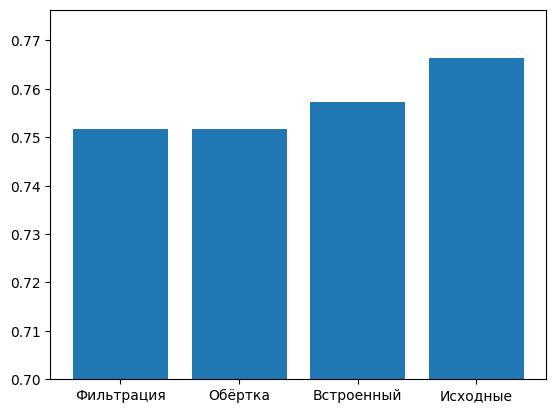

In [48]:
plt.bar(['Фильтрация', 'Обёртка', 'Встроенный', 'Исходные'], scores)
plt.gca().set_ylim([0.7, max(scores) + 0.01])
plt.show()

### Доверимся методу обёртки и удалим столбцы, которые не являются значимыми

In [49]:
# new_df = train_df.drop(columns=set(train_df.columns) - set(selector.get_feature_names_out()))
# x = new_df
x # попробовать все колонки
# Графики для сравнения

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0,0.336517,0.375,0.166667,0.049708,2
1,1.0,1,0.335260,0.000,0.000000,0.014151,2
2,0.0,0,0.535059,0.000,0.166667,0.412503,2
3,0.5,0,0.296306,0.000,0.333333,0.028302,2
4,0.5,1,0.007288,0.250,0.166667,0.076123,2
...,...,...,...,...,...,...,...
529,1.0,0,0.019854,0.375,0.333333,0.054457,2
530,1.0,0,0.032420,0.375,0.166667,0.041136,2
531,1.0,1,0.336517,0.375,0.166667,0.049708,2
532,0.5,0,0.296306,0.250,0.500000,0.036598,2


In [50]:
samples = []
scores = []
methods = ['oversampling', 'oversampling SMOTE', 'undersampling', 'undersampling Tlinks', 'SMOTETomek', 'Исходные']

In [51]:
over = RandomOverSampler(random_state=0)
samples.append(over.fit_resample(x, y))

model = GaussianNB()
cross = cross_validate(model, samples[0][0], y=samples[0][1], return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(samples[0][1], model.predict(samples[0][0])))

In [52]:
samples.append(SMOTE().fit_resample(x, y))

model = GaussianNB()
cross = cross_validate(model, samples[1][0], y=samples[1][1], return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(samples[1][1], model.predict(samples[1][0])))

In [53]:
under = RandomUnderSampler(random_state=0)
samples.append(under.fit_resample(x, y))

model = GaussianNB()
cross = cross_validate(model, samples[2][0], y=samples[2][1], return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(samples[2][1], model.predict(samples[2][0])))

In [54]:
tl = TomekLinks()
samples.append(tl.fit_resample(x, y))

model = GaussianNB()
cross = cross_validate(model, samples[3][0], y=samples[3][1], return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(samples[3][1], model.predict(samples[3][0])))

In [55]:
st = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
samples.append(st.fit_resample(x, y))

model = GaussianNB()
cross = cross_validate(model, samples[3][0], y=samples[3][1], return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(samples[3][1], model.predict(samples[3][0])))

In [56]:
model = GaussianNB()
cross = cross_validate(model, x, y=y, return_estimator=True, cv=5)
model = cross['estimator'][list(cross['test_score']).index(max(cross['test_score']))]
scores.append(roc_auc_score(y, model.predict(x)))

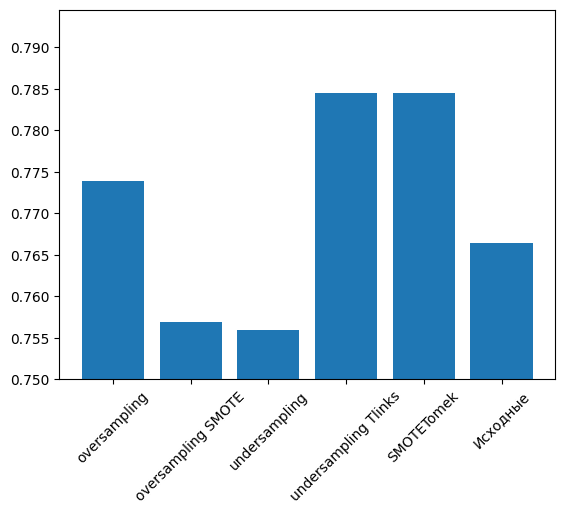

In [57]:
plt.bar(methods, scores)
plt.xticks(rotation=45)
plt.gca().set_ylim([0.75, max(scores) + 0.01])  # задаем пределы оси Y, чтобы она начиналась с 0.75
plt.show()
# y.value_counts().plot(kind='bar')
# plt.show()

### Используем undersampling Tlinks

In [58]:
x_ros, y_ros= st.fit_resample(x, y)
x = x_ros
y = y_ros

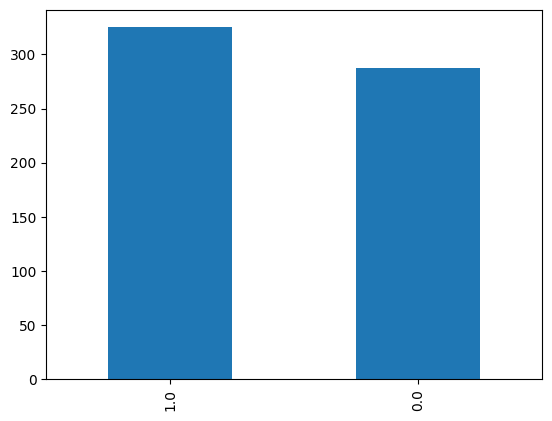

In [59]:
y.value_counts().plot(kind='bar')
plt.show()

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state=0)

### KNN

In [61]:
params = {'n_neighbors': range(1, 20),
          'weights': ('uniform', 'distance'),
          # 'metric': ('euclidean', 'manhattan', 'chebyshev'),
          'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}

knn = KNeighborsClassifier()

scoring = 'roc_auc'

grid = GridSearchCV(knn, params, scoring=scoring)
grid.fit(x_train, y_train)

print(f'Best parameters: {grid.best_params_}')
print(f'Best scores: {grid.best_score_: .2f}')
 
y_pred_prob = grid.predict_proba(x_val)
best_knn = grid.best_estimator_
models = [best_knn]
models_name = ['KNN']
roc_auc = roc_auc_score(y_val, y_pred_prob[:,1])
print(f'ROC-AUC: {roc_auc: .2f}')

Best parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Best scores:  0.89
ROC-AUC:  0.86


### Логистическая регрессия

In [62]:
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty':(None, 'l1', 'l2', 'elasticnet')}

clf = LogisticRegression()
grid = GridSearchCV(clf, parameters, scoring=scoring)
grid.fit(x_train, y_train)
best_clf = grid.best_estimator_
models.append(best_clf)
models_name.append('Logistic Regression')

print(f'Best parameters: {grid.best_params_}')
print(f'Best scores: {grid.best_score_: .2f}')
y_pred_prob = grid.predict_proba(x_val)
roc_auc = roc_auc_score(y_val, y_pred_prob[:,1])
print(f'ROC-AUC: {roc_auc: .2f}')

Best parameters: {'C': 10, 'penalty': 'l2'}
Best scores:  0.88
ROC-AUC:  0.85


### Метод опорных векторов

In [63]:
parameters = {'kernel':('rbf', 'linear'),
              'C':[0.01, 0.1, 1, 10, 100],
              # 'gamma': ('scale', 'auto'),
              # 'decision_function_shape': ('ovo', 'ovr'),
              # 'shrinking': (True, False)
             }
lsvc = SVC(probability=True)

grid = GridSearchCV(lsvc, parameters, scoring=scoring)
grid.fit(x_train, y_train)
best_lsvc = grid.best_estimator_
models.append(best_lsvc)
models_name.append('SVC')

print(f'Best parameters: {grid.best_params_}')
print(f'Best scores: {grid.best_score_: .2f}')
print(f'ROC-AUC: {roc_auc: .2f}')

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best scores:  0.88
ROC-AUC:  0.85


### Наивный байесовский классификатор

In [64]:
gaus = GaussianNB()
best_gaus = cross_validate(gaus, x_train, y_train, cv=5, return_estimator=True)
best_gaus = best_gaus['estimator'][list(best_gaus['test_score']).index(max(best_gaus['test_score']))]
best_gaus.fit(x_train, y_train)
# gaus.fit(x_train, y_train) # cross validate метод cross_validate
models.append(best_gaus)
models_name.append('GaussianNB')

scores = cross_val_score(gaus, x_train, y_train, cv=5)
print('Cross-validation scores:', ', '.join(list(map(lambda x: str(round(x, 2)), scores))))
print(f'Average score: {scores.mean(): .2f}')

Cross-validation scores: 0.84, 0.77, 0.73, 0.8, 0.79
Average score:  0.79


### Дискриминантный анализ

#### Линейный

In [65]:
disc = LinearDiscriminantAnalysis()
best_disc = cross_validate(disc, x_train, y_train, cv=5, return_estimator=True)
best_disc = best_disc['estimator'][list(best_disc['test_score']).index(max(best_disc['test_score']))]
best_disc.fit(x_train, y_train)

models.append(best_disc)
models_name.append('LinearDiscriminantAnalysis')

scores = cross_val_score(disc, x_train, y_train, cv=5)
print('Cross-validation scores:', ', '.join(list(map(lambda x: str(round(x, 2)), scores))))
print(f'Average score: {scores.mean(): .2f}')

Cross-validation scores: 0.77, 0.8, 0.85, 0.81, 0.79
Average score:  0.80


#### Квадратичный

In [66]:
quad = QuadraticDiscriminantAnalysis()
best_quad = cross_validate(quad, x_train, y_train, cv=5, return_estimator=True)
best_quad = best_quad['estimator'][list(best_quad['test_score']).index(max(best_quad['test_score']))]
best_quad.fit(x_train, y_train)

models.append(best_quad)
models_name.append('QuadraticDiscriminantAnalysis')

scores = cross_val_score(quad, x_train, y_train, cv=5)
print('Cross-validation scores:', ', '.join(list(map(lambda x: str(round(x, 2)), scores))))
print(f'Average score: {scores.mean(): .2f}')

Cross-validation scores: 0.79, 0.77, 0.76, 0.8, 0.81
Average score:  0.79


In [67]:
models_with_scores = {}
def roc_auc_plot(models, models_name, x_val, y_val):
    plt.figure(figsize=(10,7))
    plt.title('ROC-AUC graphics')

    for i, model in enumerate(models):
        y_val_predicted = model.predict_proba(x_val)[:, 1]
        plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label=f'{models_name[i]} AUC={roc_auc_score(y_val, y_val_predicted):.3f}')
        models_with_scores.update({models_name[i]: roc_auc_score(y_val, y_val_predicted)})
        legend = plt.legend(fontsize='large', framealpha=1).get_frame()
        legend.set_facecolor('white')
        legend.set_edgecolor('black')
    
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

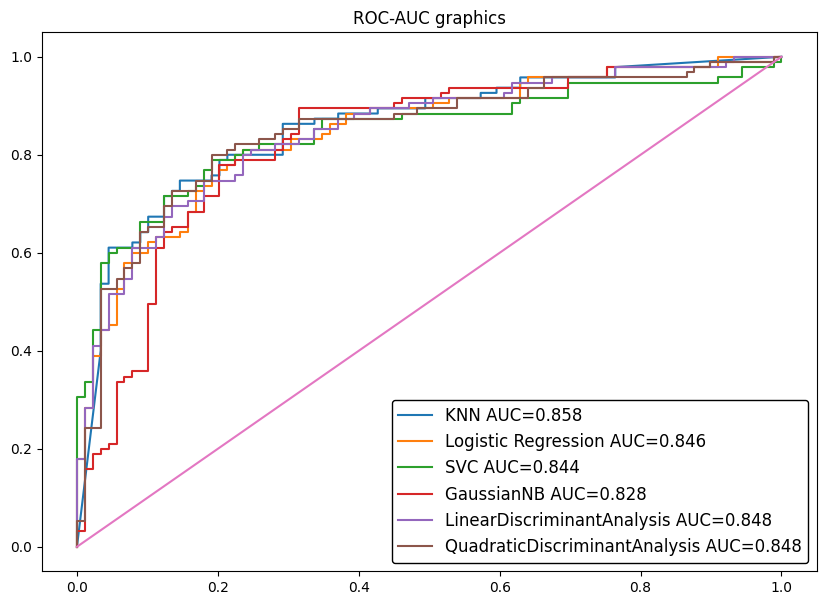

{'KNN': 0.8580721466587818, 'Logistic Regression': 0.8461265523358958, 'SVC': 0.8443524541691307, 'GaussianNB': 0.8276759314015376, 'LinearDiscriminantAnalysis': 0.8479006505026613, 'QuadraticDiscriminantAnalysis': 0.8482554701360142}


In [68]:
roc_auc_plot(models, models_name, x_val, y_val) # посмотреть встроенный метод
print(models_with_scores)

In [69]:
test_df = pd.read_csv('test.csv', sep=',', header=0, index_col=False)
cat_cols = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,357.000000,357.000000,357,357,282.000000,357.000000,357.000000,357,357.000000,84,355
unique,NaN,NaN,357,2,NaN,NaN,NaN,318,NaN,76,3
top,NaN,NaN,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",male,NaN,NaN,NaN,3101295,NaN,G6,S
freq,NaN,NaN,1,231,NaN,NaN,NaN,4,NaN,4,264
mean,456.652661,2.280112,NaN,NaN,29.831560,0.484594,0.383754,NaN,31.342261,NaN,NaN
std,259.059800,0.831252,NaN,NaN,14.217083,0.925854,0.786876,NaN,45.740960,NaN,NaN
min,4.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,239.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,8.050000,NaN,NaN
50%,465.000000,3.000000,NaN,NaN,29.000000,0.000000,0.000000,NaN,15.550000,NaN,NaN
75%,678.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.500000,NaN,NaN


In [70]:
test_id = test_df['PassengerId']
test_df = transform_data(test_df, num_cols, cat_cols, 1)
# cat_cols.remove('Embarked')
# num_cols.remove('Parch')
# num_cols.remove('Fare')
# test_df = test_df.drop(['Embarked', 'Parch', 'Fare'], axis=1)

def create_submission(id_c, pred):
    return pd.DataFrame({
        'PassengerId': id_c,
        'Survived': pred
    })

In [71]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,0,0.465753,0.125,0.0,0.101497,2
1,1.0,1,0.438356,0.000,0.0,0.015412,2
2,0.0,0,0.849315,0.125,0.0,0.152164,2
3,0.0,1,0.753425,0.000,0.0,0.069291,0
4,1.0,1,0.339726,0.000,0.0,0.015412,2


In [72]:
sub_knn = create_submission(test_id, best_clf.predict(test_df))
sub_knn['Survived'] = sub_knn['Survived'].astype(int)
sub_knn.to_csv('./best_clf.csv', index=False)